# Set up

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Dataset

In [2]:
df = pd.read_csv('__datasets/PJMW_hourly.csv') 
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [3]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace = True)
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


## Visual analysis

In [4]:
def dataset_lookup(df):
    print('Dataset info:')
    print(df.info())
    print()
    print('Dataset description:')
    print(df.describe())
    print()
    print('Amount of duplicates:')
    duplicates_amount = df.duplicated().sum()
    print(duplicates_amount)
    if (duplicates_amount > 0):
        print('Duplicates:')
        print(df[df.duplicated()])
    print()
    print('Amount of missing values:')
    print(df.isna().sum(axis = 0))
    print()
    print('Unique values in each column:')
    object_types_count = 0
    for column in df:
        if df[column].dtypes == 'object':
            object_types_count += 1
            print('-' * len(column))
            print(f'{column}: {df[column].unique()}')
    if object_types_count == 0:
        print('-' * 10)
        print('No object columns in this dataset.')
        
dataset_lookup(df)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJMW_MW  143206 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None

Dataset description:
             PJMW_MW
count  143206.000000
mean     5602.375089
std       979.142872
min       487.000000
25%      4907.000000
50%      5530.000000
75%      6252.000000
max      9594.000000

Amount of duplicates:
137863
Duplicates:
                     PJMW_MW
Datetime                    
2002-04-01 22:00:00   5783.0
2002-04-03 17:00:00   5677.0
2002-04-04 14:00:00   5728.0
2002-04-04 18:00:00   5662.0
2002-04-05 02:00:00   5045.0
...                      ...
2018-08-02 20:00:00   6545.0
2018-08-02 21:00:00   6496.0
2018-08-02 22:00:00   6325.0
2018-08-02 23:00:00   5892.0
2018-08-03 00:00:00   5489.0

[137863 rows x 1 columns]

Amount of missing valu

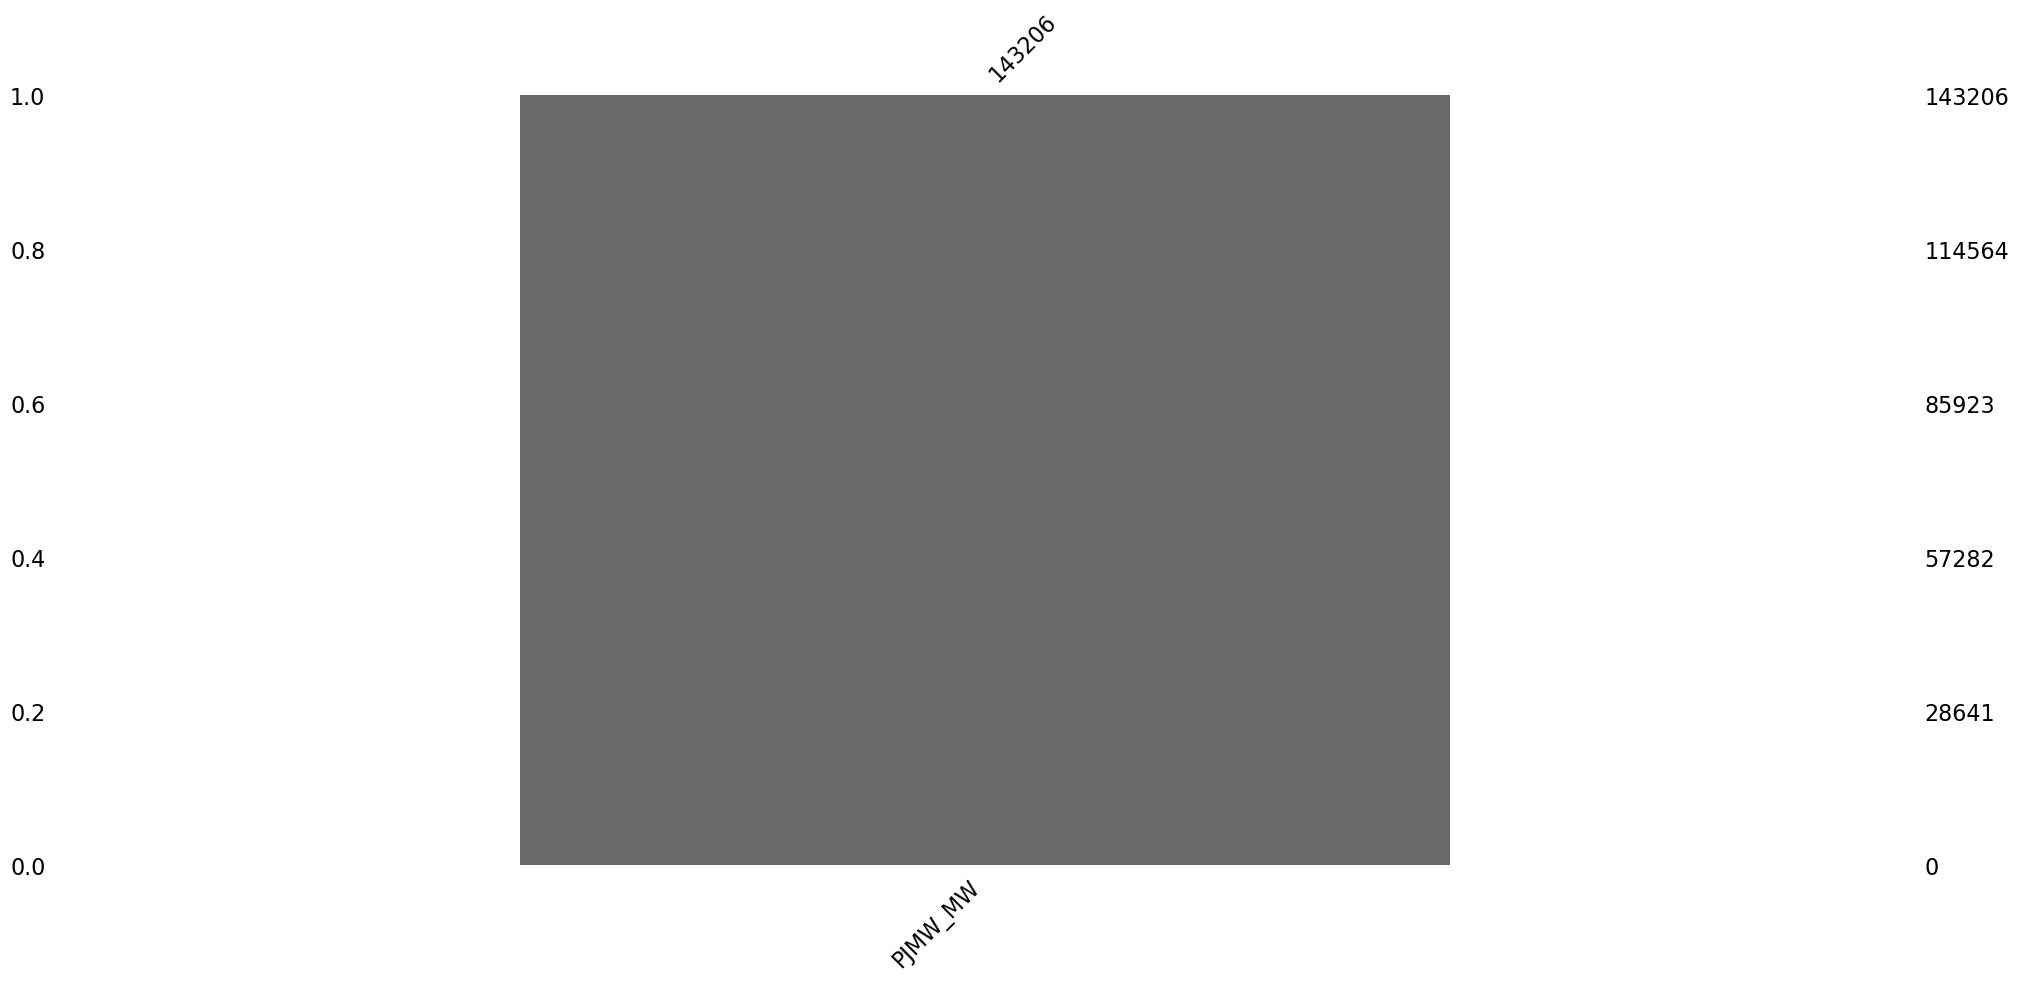

In [5]:
msno.bar(df)
plt.show()

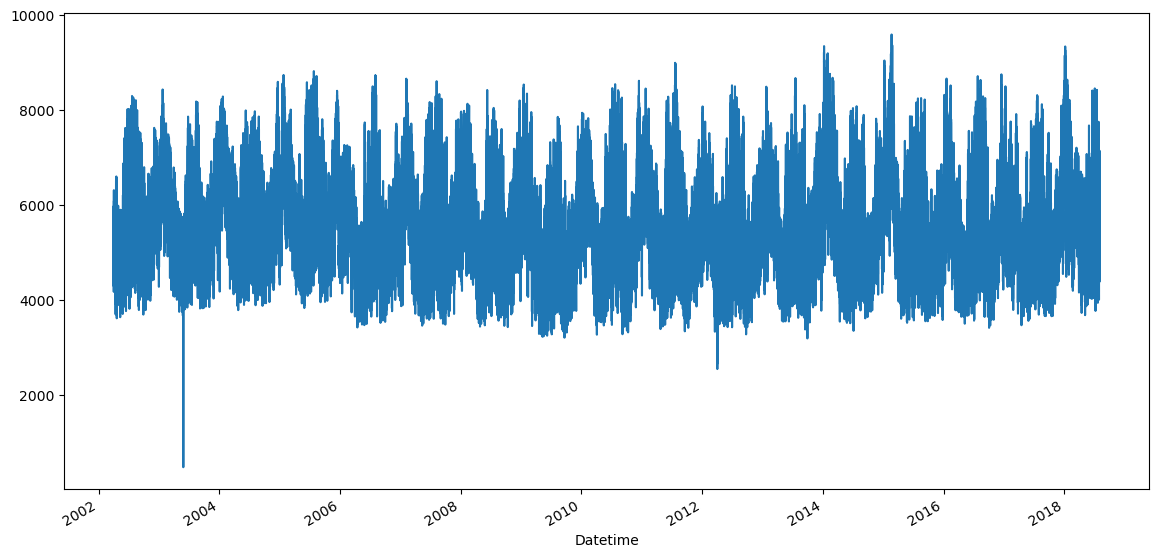

In [10]:
plt.figure(figsize = (14, 7))
df['PJMW_MW'].plot()
plt.show()

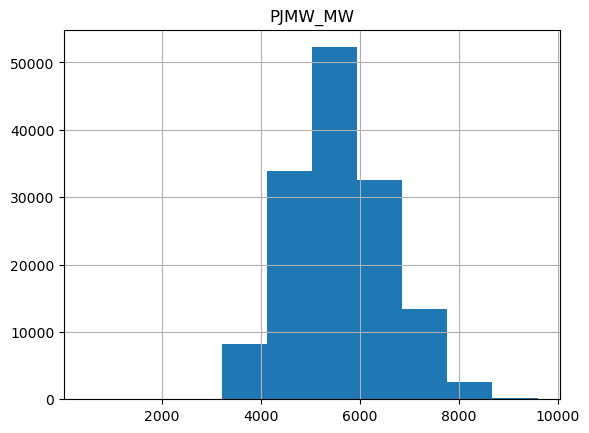

In [13]:
def plot_dataset_histograms(df):
    df.hist()
    plt.show()
    
plot_dataset_histograms(df)

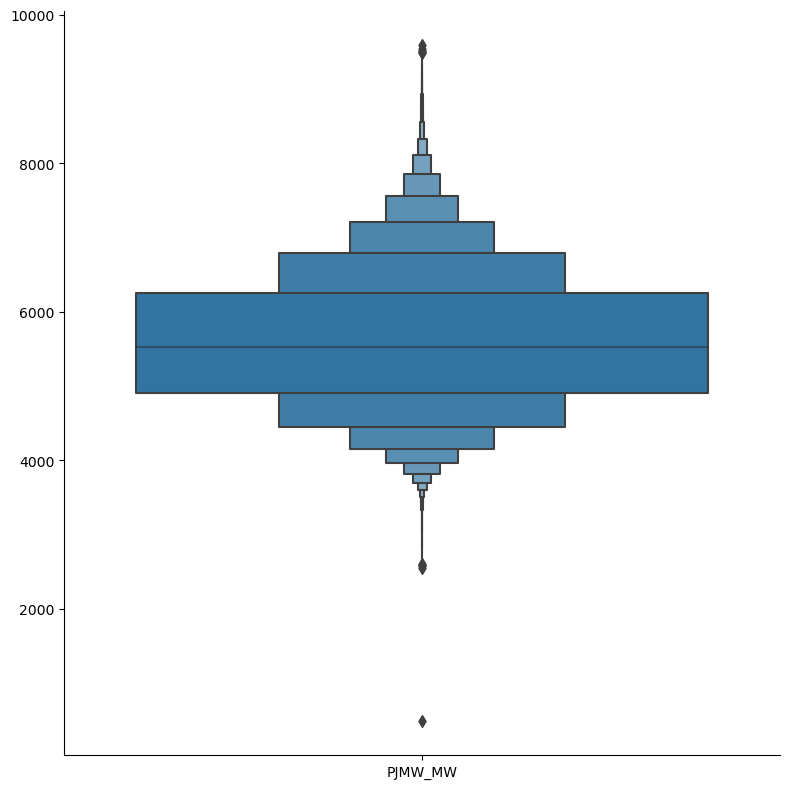

In [15]:
def show_cat_plot(df):
    sb.catplot(df, kind = 'boxen', height = 8)
    plt.show()

show_cat_plot(df)

## Exploring autocorrelation & partial autocorrelation

### Autocorrelation

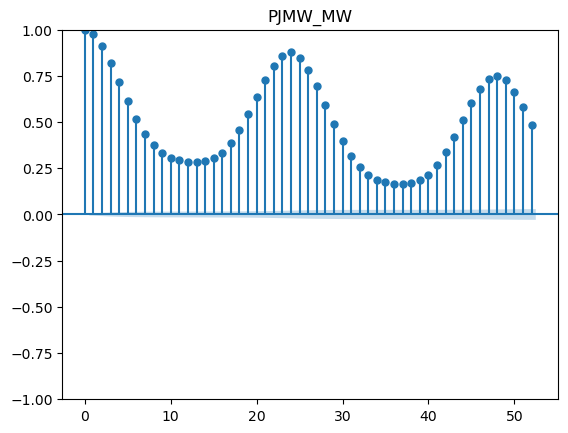

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

for column in df:
    if df[column].dtypes == 'object':
        continue
    plot_acf(df[column].to_numpy(), title = column)
    plt.show()

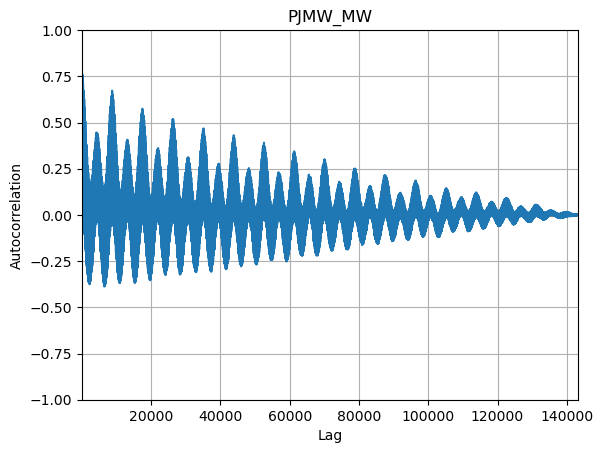

In [18]:
from pandas.plotting import autocorrelation_plot

for column in df:
    if df[column].dtypes == 'object':
        continue
    plt.title(column)
    autocorrelation_plot(df[column]) 
    plt.show()

### Partial autocorrelation

C:\Users\dexp\miniconda3\envs\env-tf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


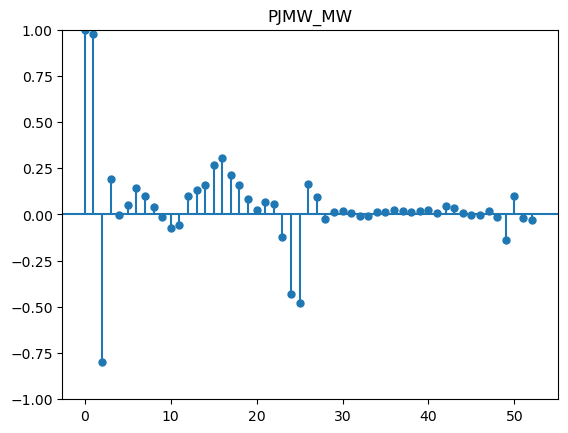

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

for column in df:
    if df[column].dtypes == 'object':
        continue
    plot_pacf(df[column].to_numpy(), title = column)
    plt.show()

##### Conclusion: the values beyond confidence interval indicate that there's some pattern in the input signal

## Exploring seasonal decomposition

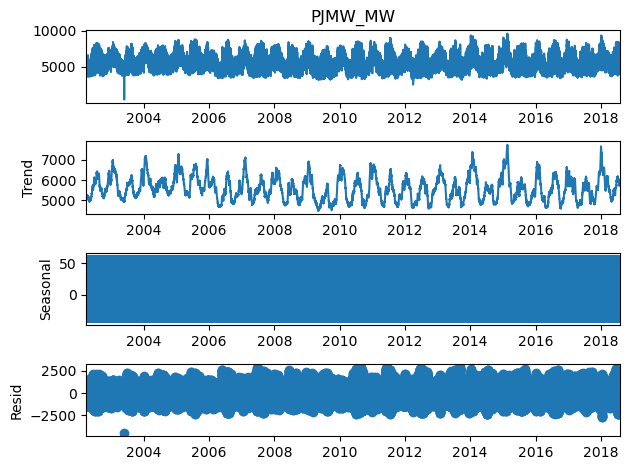

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

for column in df:
    if df[column].dtypes == 'object':
        continue
    seasonal_decompose(df[column], period = 365, model ='additive').plot()
    plt.show()

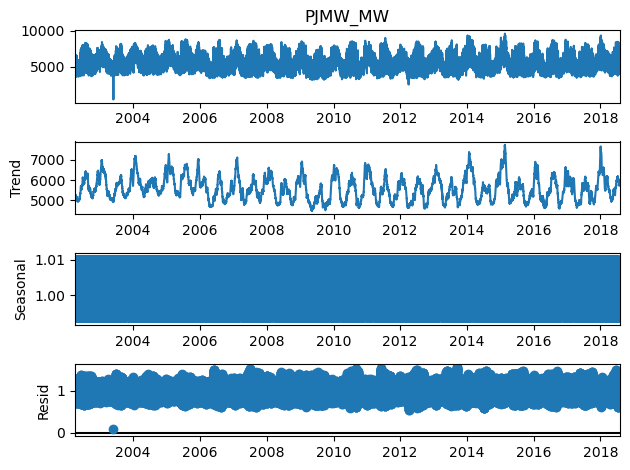

In [22]:
for column in df:
    if df[column].dtypes == 'object':
        continue
    seasonal_decompose(df[column], period = 365, model ='multiplicative').plot()
    plt.show()

## Feature engineering

### Adding time features

In [5]:
df_orig = df.copy()
df_orig

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [6]:
df_reg = df_orig.copy()

df_reg['year'] = df_reg.index.year
df_reg['quarter'] = df_reg.index.quarter
df_reg['month'] = df_reg.index.month
df_reg['week_of_year'] = pd.Index(df_reg.index.isocalendar().week)
df_reg['day'] = df_reg.index.day
df_reg['day_of_year'] = df_reg.index.dayofyear
df_reg['day_of_week'] = df_reg.index.dayofweek
df_reg['hour'] = df_reg.index.hour
df_reg.rename(columns = {'PJMW_MW': 'Target'}, inplace = True)
df_reg

,Target,year,quarter,month,week_of_year,day,day_of_year,day_of_week,hour
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,2002,2,4,14,1,91,0,1
2002-04-01 02:00:00,4306.0,2002,2,4,14,1,91,0,2
2002-04-01 03:00:00,4322.0,2002,2,4,14,1,91,0,3
2002-04-01 04:00:00,4359.0,2002,2,4,14,1,91,0,4
2002-04-01 05:00:00,4436.0,2002,2,4,14,1,91,0,5
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,2018,3,8,31,2,214,3,20
2018-08-02 21:00:00,6496.0,2018,3,8,31,2,214,3,21
2018-08-02 22:00:00,6325.0,2018,3,8,31,2,214,3,22


In [7]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Target        143206 non-null  float64
 1   year          143206 non-null  int64  
 2   quarter       143206 non-null  int64  
 3   month         143206 non-null  int64  
 4   week_of_year  143206 non-null  UInt32 
 5   day           143206 non-null  int64  
 6   day_of_year   143206 non-null  int64  
 7   day_of_week   143206 non-null  int64  
 8   hour          143206 non-null  int64  
dtypes: UInt32(1), float64(1), int64(7)
memory usage: 10.5 MB


In [8]:
df_reg['week_of_year'] = df_reg['week_of_year'].astype(int)
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Target        143206 non-null  float64
 1   year          143206 non-null  int64  
 2   quarter       143206 non-null  int64  
 3   month         143206 non-null  int64  
 4   week_of_year  143206 non-null  int32  
 5   day           143206 non-null  int64  
 6   day_of_year   143206 non-null  int64  
 7   day_of_week   143206 non-null  int64  
 8   hour          143206 non-null  int64  
dtypes: float64(1), int32(1), int64(7)
memory usage: 10.4 MB


#### Showcase of time features

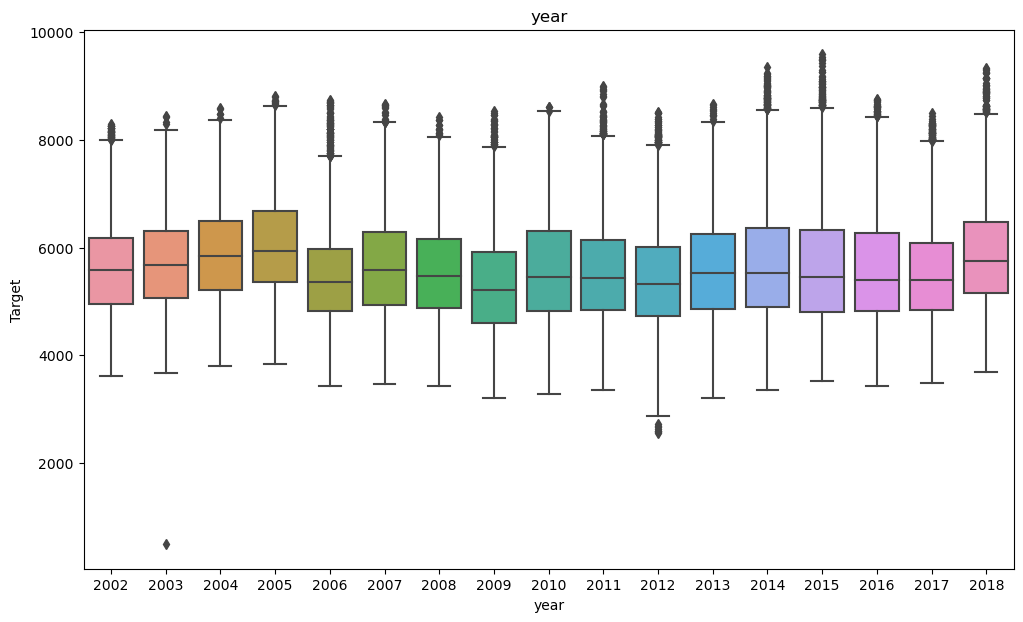

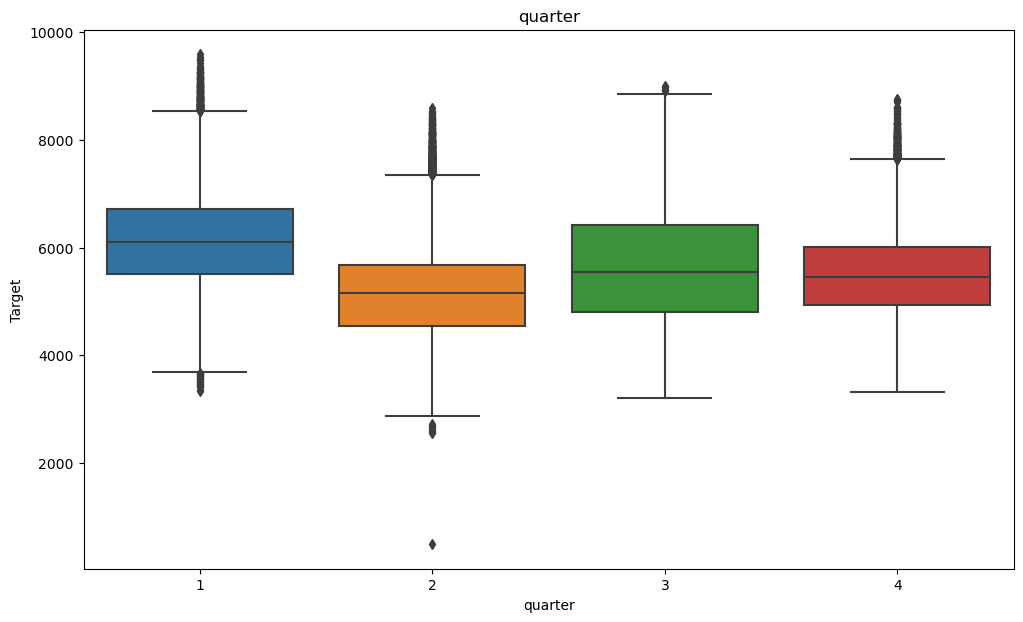

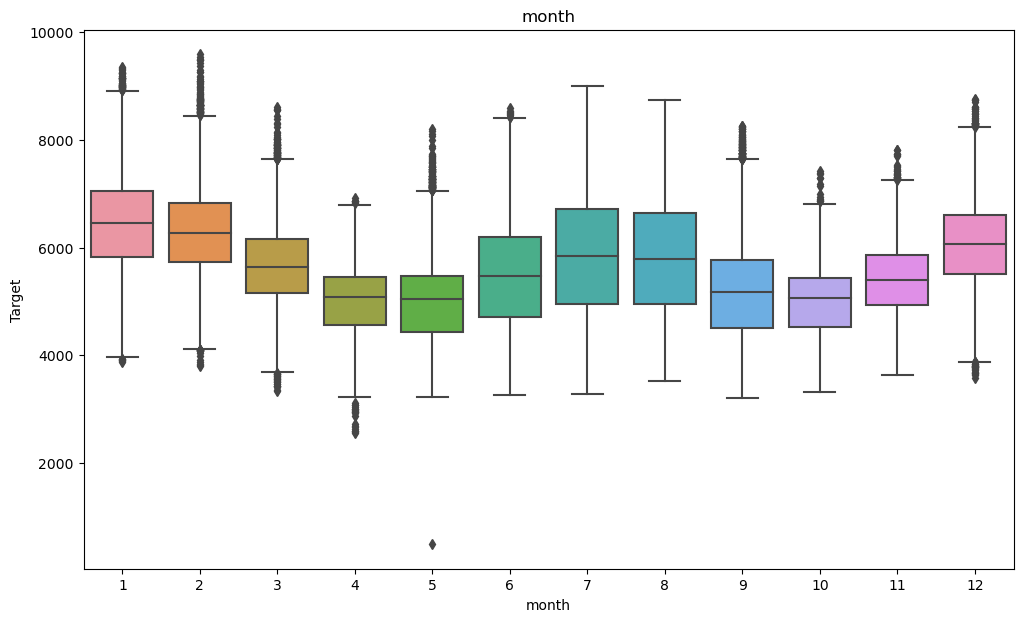

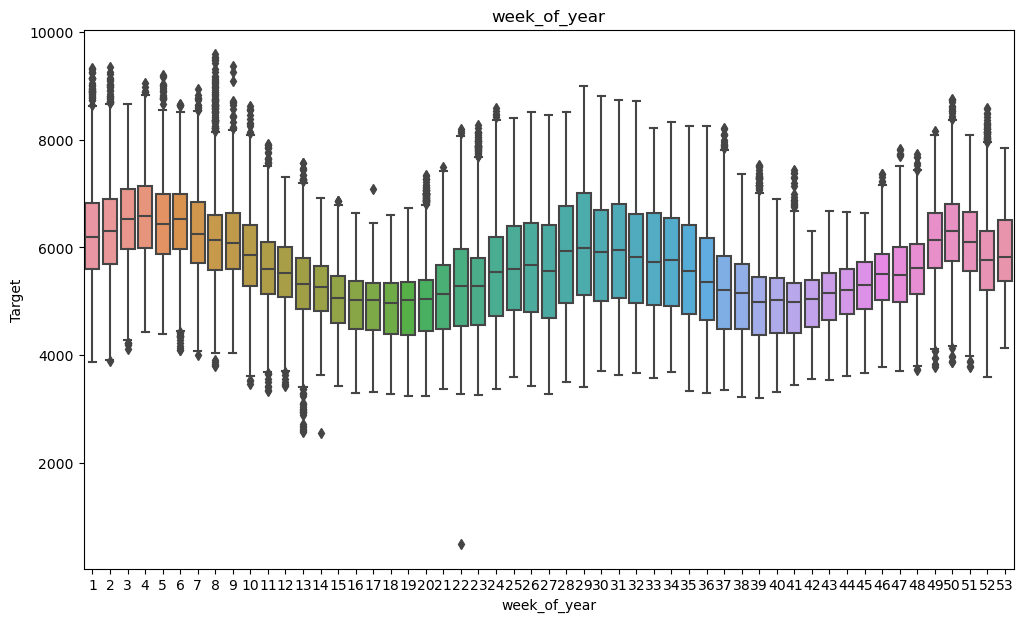

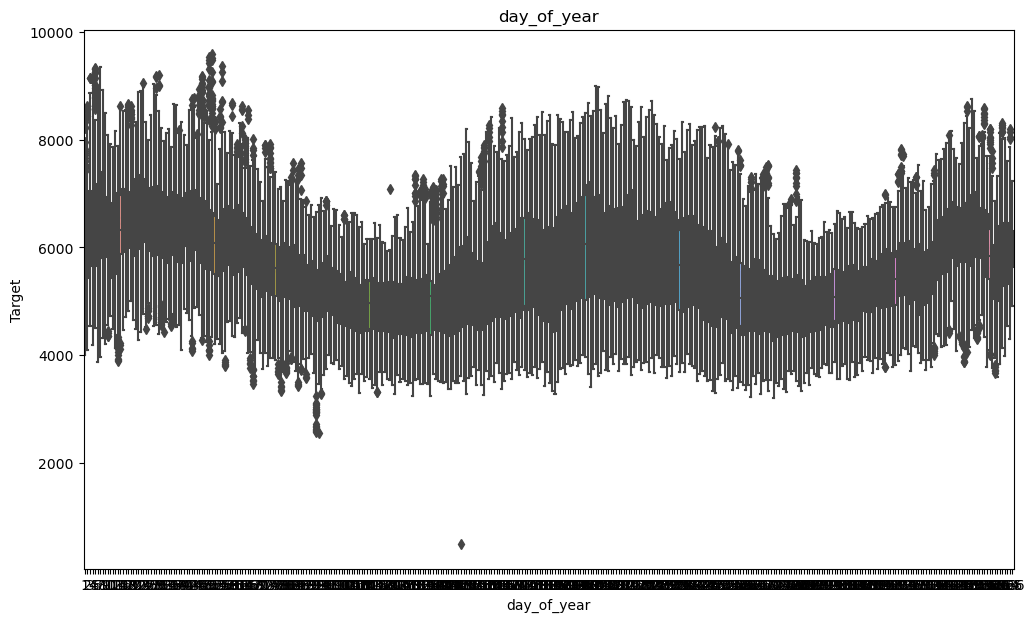

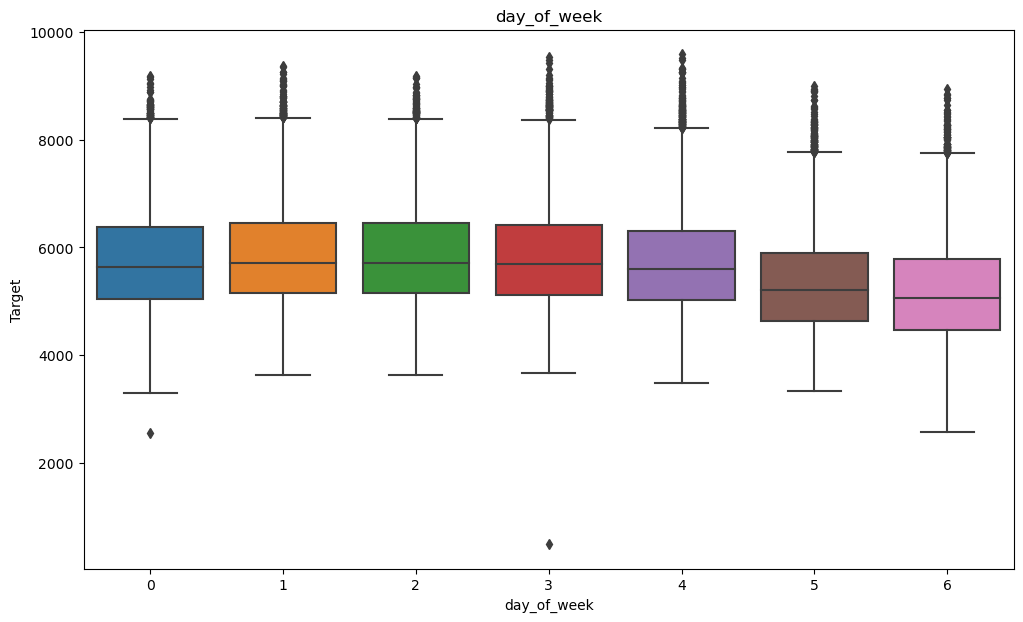

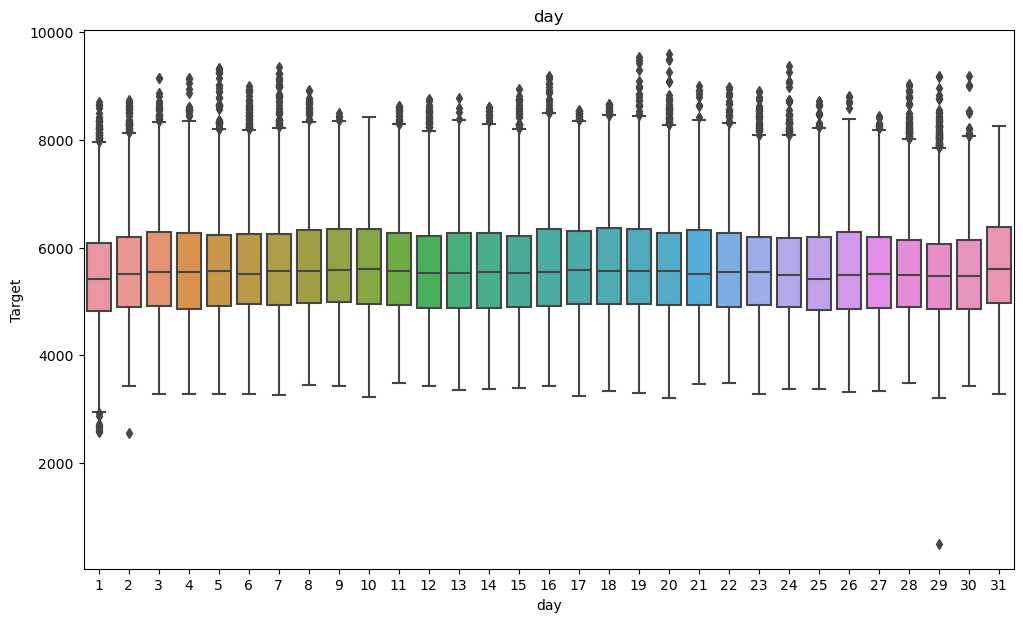

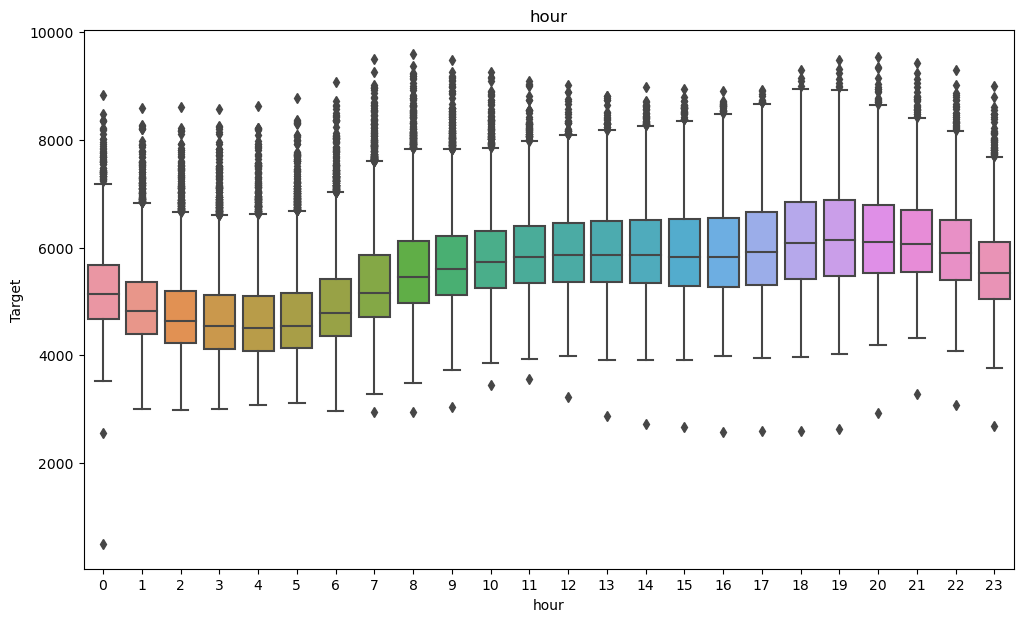

In [9]:
columns = ['year', 'quarter', 'month', 'week_of_year', 'day_of_year', 'day_of_week', 'day', 'hour']
for column in columns:
    plt.figure(figsize = (12, 7))
    plt.title(column)
    sb.boxplot(x = column, y = 'Target', data = df_reg)
    plt.show()

### Adding the direction change value for classification problem

In [10]:
df_reg

,Target,year,quarter,month,week_of_year,day,day_of_year,day_of_week,hour
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,2002,2,4,14,1,91,0,1
2002-04-01 02:00:00,4306.0,2002,2,4,14,1,91,0,2
2002-04-01 03:00:00,4322.0,2002,2,4,14,1,91,0,3
2002-04-01 04:00:00,4359.0,2002,2,4,14,1,91,0,4
2002-04-01 05:00:00,4436.0,2002,2,4,14,1,91,0,5
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,6545.0,2018,3,8,31,2,214,3,20
2018-08-02 21:00:00,6496.0,2018,3,8,31,2,214,3,21
2018-08-02 22:00:00,6325.0,2018,3,8,31,2,214,3,22


In [11]:
df_clf = df_reg.copy()
df_clf['Tomorrow'] = df_clf['Target'].shift(-1)
df_clf['Class_Target'] = (df_clf['Tomorrow'] > df_clf['Target']).astype(int)
df_clf.drop(columns = ['Tomorrow', 'Target'], inplace = True)
df_clf

,year,quarter,month,week_of_year,day,day_of_year,day_of_week,hour,Class_Target
Datetime,,,,,,,,,
2002-04-01 01:00:00,2002,2,4,14,1,91,0,1,0
2002-04-01 02:00:00,2002,2,4,14,1,91,0,2,1
2002-04-01 03:00:00,2002,2,4,14,1,91,0,3,1
2002-04-01 04:00:00,2002,2,4,14,1,91,0,4,1
2002-04-01 05:00:00,2002,2,4,14,1,91,0,5,1
...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,2018,3,8,31,2,214,3,20,0
2018-08-02 21:00:00,2018,3,8,31,2,214,3,21,0
2018-08-02 22:00:00,2018,3,8,31,2,214,3,22,0


In [12]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   year          143206 non-null  int64
 1   quarter       143206 non-null  int64
 2   month         143206 non-null  int64
 3   week_of_year  143206 non-null  int32
 4   day           143206 non-null  int64
 5   day_of_year   143206 non-null  int64
 6   day_of_week   143206 non-null  int64
 7   hour          143206 non-null  int64
 8   Class_Target  143206 non-null  int32
dtypes: int32(2), int64(7)
memory usage: 9.8 MB


#### Showcase of direction class distribution

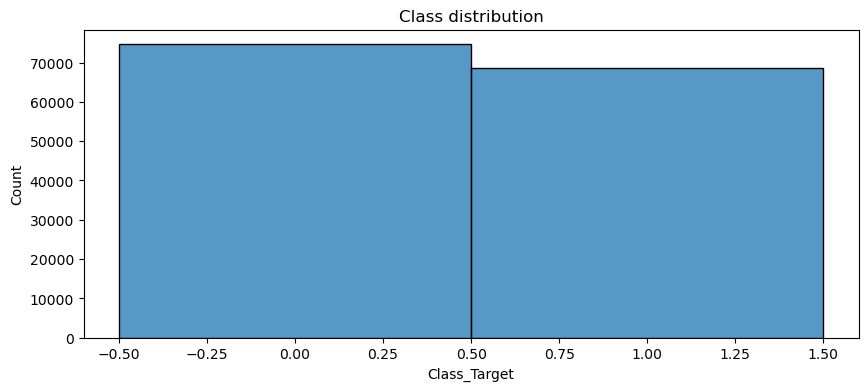

In [47]:
def show_class_distribution(y, encoder = None):
    plt.figure(figsize = (10, 4))
    plt.title('Class distribution')
    if encoder != None:
        sb.histplot(encoder.inverse_transform(y), discrete = True)
    else:
        sb.histplot(y, discrete = True)
    plt.show()
    
show_class_distribution(df_clf['Class_Target'])

# CV for time series regression

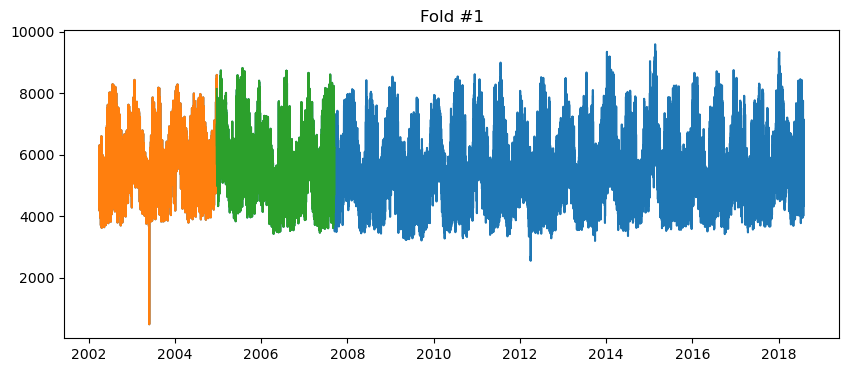

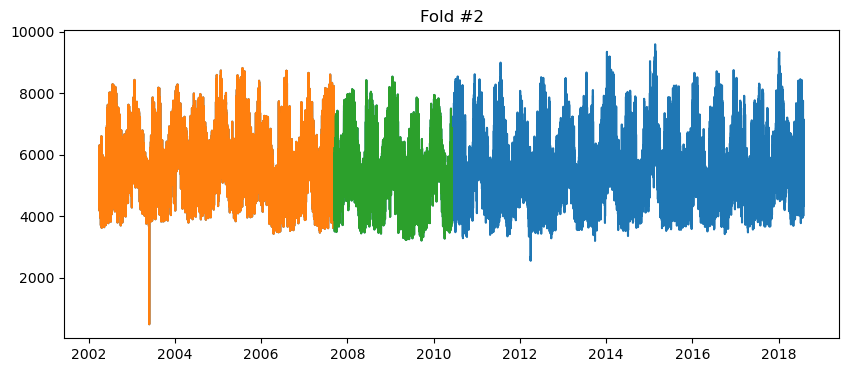

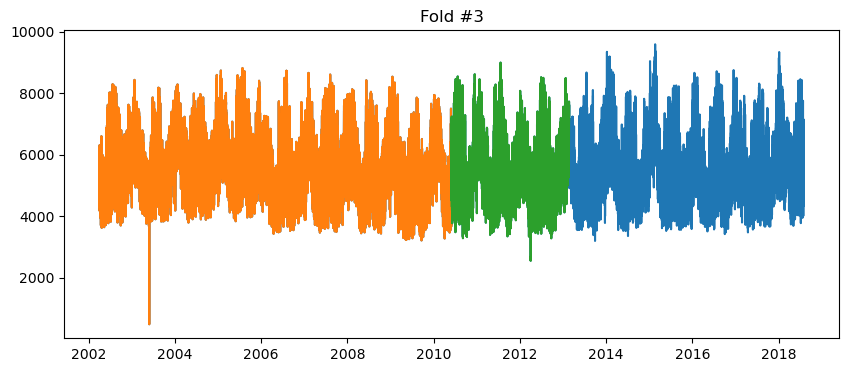

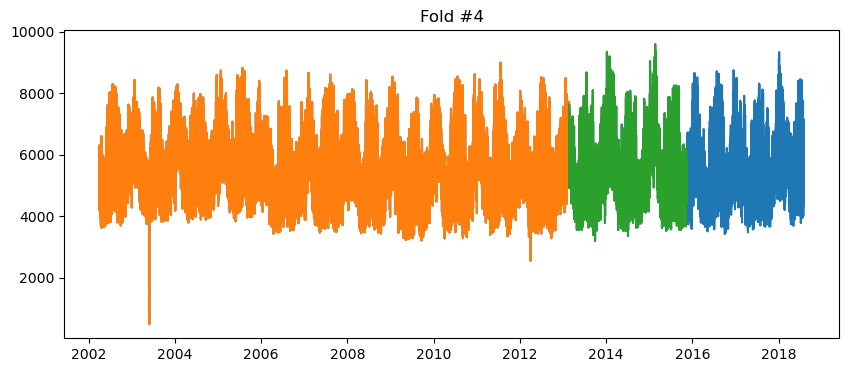

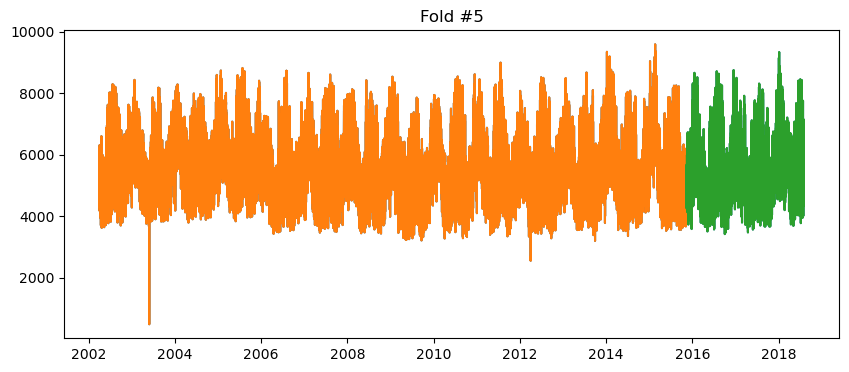

In [13]:
from sklearn.model_selection import TimeSeriesSplit

i = 1
timeSeriesSplit = TimeSeriesSplit(n_splits = 5)
for train, test in timeSeriesSplit.split(df_reg):
    plt.figure(figsize = (10, 4))
    plt.title(f'Fold #{i}')
    plt.plot(df_reg['Target'])
    plt.plot(df_reg.iloc[train]['Target'])
    plt.plot(df_reg.iloc[test]['Target'])
    plt.show()
    i += 1

## Regression CV

### ML

In [14]:
def scale_train_and_test(train, test, columns_to_scale):
    scaler = StandardScaler()
    train_scaled_columns = scaler.fit_transform(train[columns_to_scale])
    test_scaled_columns = scaler.transform(test[columns_to_scale])
    columns = list(train.columns)
    for column in columns_to_scale:
        columns.remove(column)
    train_scaled = pd.DataFrame(
        train.drop(columns = columns_to_scale),
        index = train.index,
        columns = columns) 
    for i, column in enumerate(columns_to_scale):
        train_scaled[column] = train_scaled_columns.T[i]
    test_scaled = pd.DataFrame(
        test.drop(columns = columns_to_scale),
        index = test.index,
        columns = columns) 
    for i, column in enumerate(columns_to_scale):
        test_scaled[column] = test_scaled_columns.T[i]
    return train_scaled, test_scaled, scaler

LR model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
KNN model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
CART model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
RF model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
XT model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
BG model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
ADA model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
HG model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
XGB model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
CAT model...
Fold #1...


Default metric period is 5 because MAE is/are not implemented for GPU


Fold #2...


Default metric period is 5 because MAE is/are not implemented for GPU


Fold #3...


Default metric period is 5 because MAE is/are not implemented for GPU


Fold #4...


Default metric period is 5 because MAE is/are not implemented for GPU


Fold #5...


Default metric period is 5 because MAE is/are not implemented for GPU


Done!


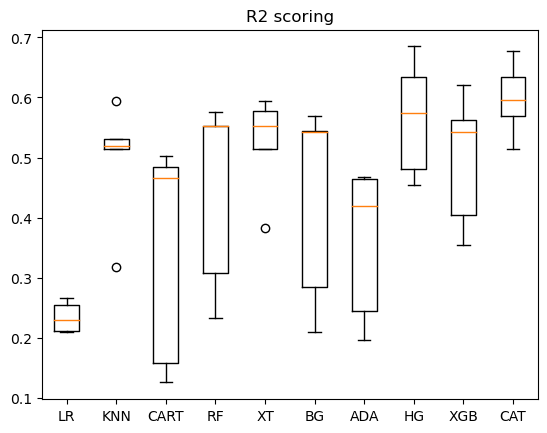

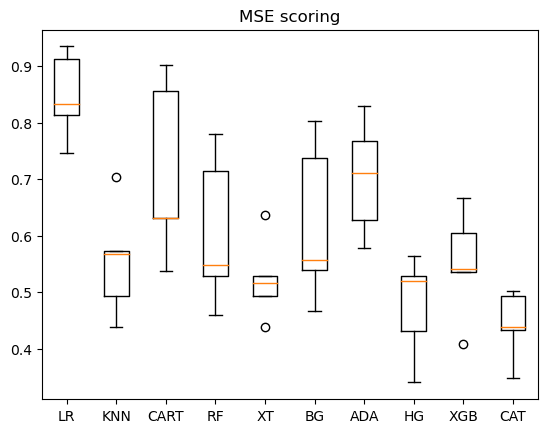

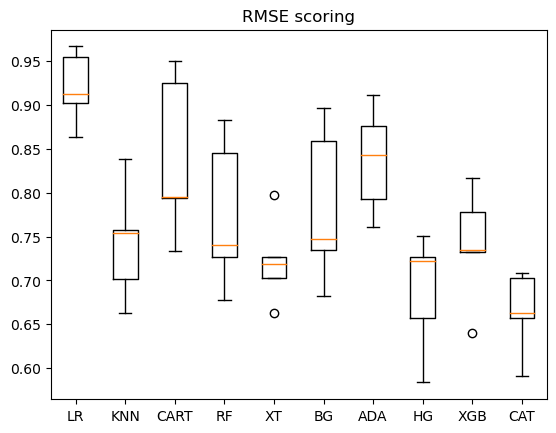

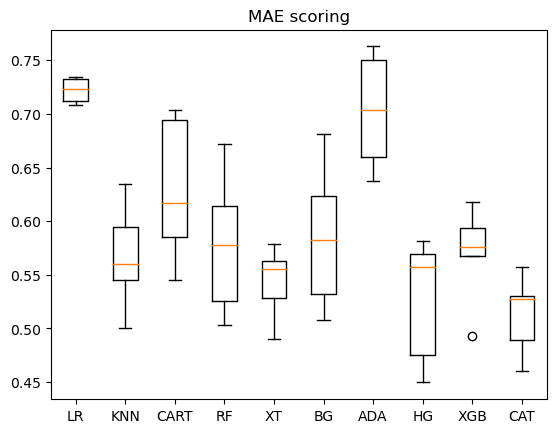

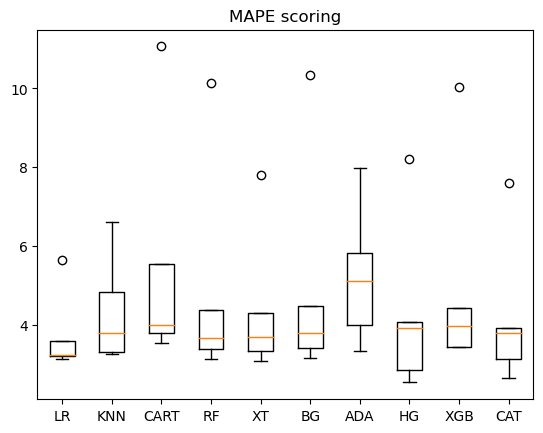

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = []
models.append(('LR', LinearRegression(n_jobs = -1)))
models.append(('KNN', KNeighborsRegressor(n_neighbors = 20, n_jobs = -1)))
models.append(('CART', DecisionTreeRegressor(random_state = 42)))
models.append(('RF', RandomForestRegressor(n_jobs = -1, random_state = 42)))
models.append(('XT', ExtraTreesRegressor(n_jobs = -1, random_state = 42)))
models.append(('BG', BaggingRegressor(n_jobs = -1, random_state = 42)))
models.append(('ADA', AdaBoostRegressor(random_state = 42)))
models.append(('HG', HistGradientBoostingRegressor(random_state = 42)))
models.append(('XGB', XGBRegressor(tree_method = 'gpu_hist', verbosity = 0, random_state = 42)))
models.append(('CAT', CatBoostRegressor(
    random_seed = 42,
    loss_function = 'MAE',
    eval_metric = 'MAPE',
    od_type = 'Iter',
    od_wait = 20,
    task_type = 'GPU',
    logging_level = 'Silent')))

results = {
    'r2' : [],
    'mse' : [],
    'rmse' : [],
    'mae' : [],
    'mape' : []
}
names = []
for name, model in models:
    names.append(name)
    print(f'{name} model...')
    timeFold = TimeSeriesSplit(n_splits = 5)
    model_results = {
        'r2' : [],
        'mse' : [],
        'rmse' : [],
        'mae' : [],
        'mape' : []
    }
    fold_num = 1
    for train_range, test_range in timeFold.split(df_reg):
        print(f'Fold #{fold_num}...')
        train = df_reg.iloc[train_range]
        test = df_reg.iloc[test_range]
        columns_to_scale = ['Target']
        train_scaled, test_scaled, _ = scale_train_and_test(train, test, columns_to_scale)
        x_train = train_scaled.drop(columns = 'Target')
        y_train = train_scaled['Target']
        x_test = test_scaled.drop(columns = 'Target')
        y_test = test_scaled['Target']
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        model_results['r2'].append(r2(y_test, y_pred))
        model_results['mse'].append(mse(y_test, y_pred))
        model_results['rmse'].append(np.sqrt(mse(y_test, y_pred)))
        model_results['mae'].append(mae(y_test, y_pred))
        model_results['mape'].append(mape(y_test, y_pred))
        fold_num += 1
    for model_result_key, model_result_value in model_results.items():
        results[model_result_key].append(model_result_value)
    print('Done!')
for result_key, result_value in results.items():
    plt.title(f'{result_key.upper()} scoring')    
    plt.boxplot(result_value, labels = names)
    plt.show()

##### Seems like the CatBoost regressor gives the best results on this dataset

### DL

In [16]:
def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dropout, Dense, SimpleRNN, GRU, LSTM

# List of devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
dl_models = []
fc = Sequential(
[
    Input(shape = (df_reg.shape[1] - 1, 1,)),
    Dense(20, activation = 'relu'),
    Dropout(0.15),
    Dense(10, activation = 'relu'),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(1)
])
rnn = Sequential(
[
    Input(shape = (df_reg.shape[1] - 1, 1,)),
    SimpleRNN(20, return_sequences = True),
    Dropout(0.15),
    SimpleRNN(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(1)
])
gru = Sequential(
[
    Input(shape = (df_reg.shape[1] - 1, 1,)),
    GRU(20, return_sequences = True),
    Dropout(0.15),
    GRU(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(1)
])
lstm = Sequential(
[
    Input(shape = (df_reg.shape[1] - 1, 1,)),
    LSTM(20, return_sequences = True),
    Dropout(0.15),
    LSTM(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(1)
])
dl_models.append(('RNN', rnn))
dl_models.append(('GRU', gru))
dl_models.append(('LSTM', lstm))
dl_models.append(('FC', fc))

batch_size = 32
epochs = 5
results = {
    'r2' : [],
    'mse' : [],
    'rmse' : [],
    'mae' : [],
    'mape' : []
}
names = []
for name, model in dl_models:
    names.append(name)
    print(f'{name} model...')
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam')
    timeFold = TimeSeriesSplit(n_splits = 5)
    model_results = {
        'r2' : [],
        'mse' : [],
        'rmse' : [],
        'mae' : [],
        'mape' : []
    }
    fold_num = 1
    for train_range, test_range in timeFold.split(df_reg):
        print(f'Fold #{fold_num}...')
        train = df_reg.iloc[train_range]
        test = df_reg.iloc[test_range]
        columns_to_scale = ['Target']
        train_scaled, test_scaled, _ = scale_train_and_test(train, test, columns_to_scale)
        x_train = train_scaled.drop(columns = 'Target')
        y_train = train_scaled['Target']
        x_test = test_scaled.drop(columns = 'Target')
        y_test = test_scaled['Target']
        train_history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = batch_size,
            epochs = epochs,
            verbose = 0).history
        y_pred = model.predict(x_test, verbose = 0)
        model_results['r2'].append(r2(y_test, y_pred))
        model_results['mse'].append(mse(y_test, y_pred))
        model_results['rmse'].append(np.sqrt(mse(y_test, y_pred)))
        model_results['mae'].append(mae(y_test, y_pred))
        model_results['mape'].append(mape(y_test, y_pred))
        show_training_history(train_history, ['loss'], ['Loss'])
        fold_num += 1
    for model_result_key, model_result_value in model_results.items():
        results[model_result_key].append(model_result_value)
    print('Done!')
for result_key, result_value in results.items():
    plt.title(f'{result_key.upper()} scoring')    
    plt.boxplot(result_value, labels = names)
    plt.show()

RNN model...
Fold #1...
Epoch 1/5


KeyboardInterrupt: 

## Classification CV

### ML

LgR model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
LDA model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
KNN model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
NB model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
CART model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
RF model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
XT model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
BG model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
ADA model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
HG model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
XGB model...
Fold #1...
Fold #2...
Fold #3...
Fold #4...
Fold #5...
Done!
CAT model...
Fold #1...


Fold #2...


Fold #3...


Fold #4...


Fold #5...


Done!


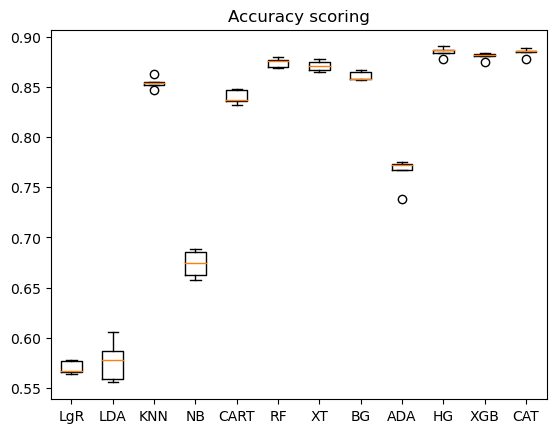

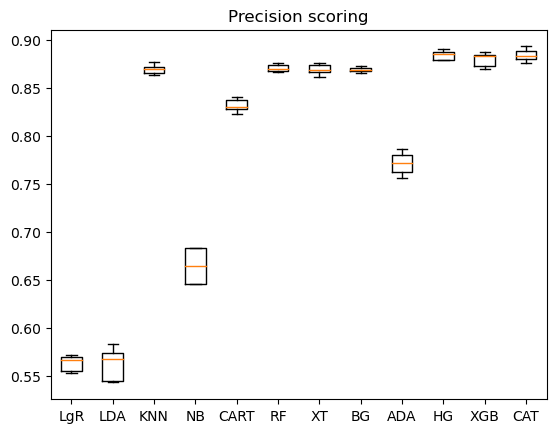

In [29]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

models = []
models.append(('LgR', LogisticRegression(random_state = 42, n_jobs = -1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 20, n_jobs = -1)))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(n_jobs = -1, random_state = 42)))
models.append(('XT', ExtraTreesClassifier(n_jobs = -1, random_state = 42)))
models.append(('BG', BaggingClassifier(n_jobs = -1, random_state = 42)))
models.append(('ADA', AdaBoostClassifier(random_state = 42)))
models.append(('HG', HistGradientBoostingClassifier(random_state = 42)))
models.append(('XGB', XGBClassifier(tree_method = 'gpu_hist', verbosity = 0, random_state = 42)))
models.append(('CAT', CatBoostClassifier(
    random_seed = 42,
    loss_function = 'CrossEntropy',
    eval_metric = 'Precision',
    od_type = 'Iter',
    od_wait = 20,
    task_type = 'GPU',
    logging_level = 'Silent')))

results = {
    'accuracy' : [],
    'precision' : []
}
names = []
for name, model in models:
    names.append(name)
    print(f'{name} model...')
    timeFold = TimeSeriesSplit(n_splits = 5)
    model_results = {
        'accuracy' : [],
        'precision' : []
    }
    fold_num = 1
    for train_range, test_range in timeFold.split(df_clf):
        print(f'Fold #{fold_num}...')
        train = df_clf.iloc[train_range]
        test = df_clf.iloc[test_range]
        # Apparently there are no columns to scale
        # There are only ordinal and class features
        #columns_to_scale = []
        #train_scaled, test_scaled, _ = scale_train_and_test(train, test, columns_to_scale)
        #x_train = train_scaled.drop(columns = 'Class_Target')
        #y_train = train_scaled['Class_Target']
        #x_test = test_scaled.drop(columns = 'Class_Target')
        #y_test = test_scaled['Class_Target']
        x_train = train.drop(columns = 'Class_Target')
        y_train = train['Class_Target']
        x_test = test.drop(columns = 'Class_Target')
        y_test = test['Class_Target']
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        model_results['accuracy'].append(accuracy(y_test, y_pred))
        model_results['precision'].append(precision(y_test, y_pred))
        fold_num += 1
    for model_result_key, model_result_value in model_results.items():
        results[model_result_key].append(model_result_value)
    print('Done!')
for result_key, result_value in results.items():
    plt.title(f'{result_key.capitalize()} scoring')    
    plt.boxplot(result_value, labels = names)
    plt.show()

### DL

In [33]:
dl_models = []
class_num = len(df_clf['Class_Target'].unique())
output_layer_activation = 'sigmoid' if class_num == 2 else 'softmax'
fc = Sequential(
[
    Input(shape = (df_clf.shape[1] - 1, 1,)),
    Dense(20, activation = 'relu'),
    Dropout(0.15),
    Dense(10, activation = 'relu'),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(class_num, activation = output_layer_activation)
])
rnn = Sequential(
[
    Input(shape = (df_clf.shape[1] - 1, 1,)),
    SimpleRNN(20, return_sequences = True),
    Dropout(0.15),
    SimpleRNN(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(class_num, activation = output_layer_activation)
])
gru = Sequential(
[
    Input(shape = (df_clf.shape[1] - 1, 1,)),
    GRU(20, return_sequences = True),
    Dropout(0.15),
    GRU(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(class_num, activation = output_layer_activation)
])
lstm = Sequential(
[
    Input(shape = (df_clf.shape[1] - 1, 1,)),
    LSTM(20, return_sequences = True),
    Dropout(0.15),
    LSTM(10),
    Dropout(0.25),
    Dense(5, activation = 'relu'),
    Dense(class_num, activation = output_layer_activation)
])
dl_models.append(('RNN', rnn))
dl_models.append(('GRU', gru))
dl_models.append(('LSTM', lstm))
dl_models.append(('FC', fc))

batch_size = 32
epochs = 5
results = {
    'accuracy' : [],
    'precision' : []
}
names = []
for name, model in dl_models:
    names.append(name)
    print(f'{name} model...')
    model.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = 'adam')
    timeFold = TimeSeriesSplit(n_splits = 5)
    model_results = {
        'accuracy' : [],
        'precision' : []
    }
    fold_num = 1
    for train_range, test_range in timeFold.split(df_clf):
        print(f'Fold #{fold_num}...')
        train = df_clf.iloc[train_range]
        test = df_clf.iloc[test_range]
        #columns_to_scale = [']
        #train_scaled, test_scaled, _ = scale_train_and_test(train, test, columns_to_scale)
        #x_train = train_scaled.drop(columns = 'Target')
        #y_train = train_scaled['Target']
        #x_test = test_scaled.drop(columns = 'Target')
        #y_test = test_scaled['Target']
        x_train = train.drop(columns = 'Class_Target')
        y_train = train['Class_Target']
        x_test = test.drop(columns = 'Class_Target')
        y_test = test['Class_Target']
        train_history = model.fit(
            x = x_train,
            y = y_train,
            batch_size = batch_size,
            epochs = epochs,
            verbose = 0).history
        y_pred = model.predict(x_test, verbose = 0)
        model_results['accuracy'].append(accuracy(y_test, y_pred))
        model_results['precision'].append(precision(y_test, y_pred))
        show_training_history(train_history, ['loss'], ['Loss'])
        fold_num += 1
    for model_result_key, model_result_value in model_results.items():
        results[model_result_key].append(model_result_value)
    print('Done!')
for result_key, result_value in results.items():
    plt.title(f'{result_key.upper()} scoring')    
    plt.boxplot(result_value, labels = names)
    plt.show()

RNN model...
Fold #1...


KeyboardInterrupt: 